In [ ]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.1 MB/s eta 0:00:00


In [ ]:
import locale
print(locale.getpreferredencoding())

UTF-8


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Training Loss: 2.2684
Epoch 1 - Validation Loss: 1.9442
Epoch 2 - Training Loss: 1.9492
Epoch 2 - Validation Loss: 1.8175
Epoch 3 - Training Loss: 1.7929
Epoch 3 - Validation Loss: 1.7554
Epoch 4 - Training Loss: 1.7322
Epoch 4 - Validation Loss: 1.7130
Epoch 5 - Training Loss: 1.6773
Epoch 5 - Validation Loss: 1.6855
Target:  "It is an appeal by special leave from a judgment of the High Court of Judicature at Calcutta answering a reference by the Income-tax Appellate Tribunal under s. 66 (2) of the Indian Income-tax Act, 1922, which was issued on the 26th day of March, 1946, for the assessment of a firm consisting of two brothers as partners dealing mainly in silver and kept its books of account on the mercantile basis. On the finding of the Income-tax authorities that the 582 bars of silver lying at Bikaner had not been really sold but remained part of the unsold stock of the firm's business at the end of the accounting year, the whole of the profits of that year must be ta

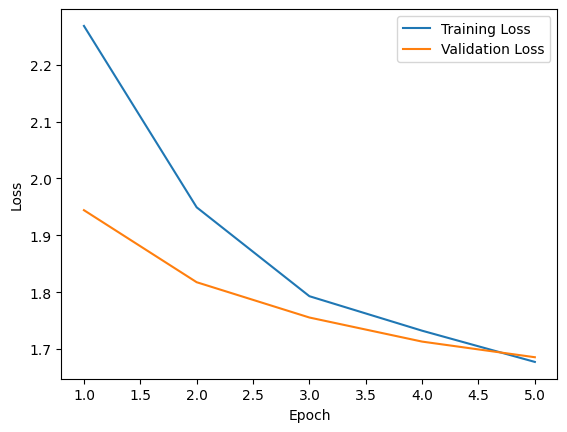

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
import matplotlib.pyplot as plt

# Step 1: Load the Dataset
df = pd.read_excel("/content/Golden_summary.xlsx")

# Step 2: Split the Dataset into Train, Test, and Validation Sets
train_text, test_text, train_summary, test_summary = train_test_split(
    df['Judgment'], df['Golden summary'], test_size=0.3, random_state=32
)
test_text, val_text, test_summary, val_summary = train_test_split(
    test_text, test_summary, test_size=0.5, random_state=32
)

model_name = 'google/pegasus-xsum'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

# Step 4: Tokenize the Data
train_encodings = tokenizer(list(train_text), truncation=True, padding=True, max_length=512)
train_labels = tokenizer(list(train_summary.astype(str)), truncation=True, padding=True, max_length=128)

val_encodings = tokenizer(list(val_text), truncation=True, padding=True, max_length=512)
val_labels = tokenizer(list(val_summary.astype(str)), truncation=True, padding=True, max_length=128)

test_encodings = tokenizer(list(test_text), truncation=True, padding=True, max_length=512)
test_labels = tokenizer(list(test_summary.astype(str)), truncation=True, padding=True, max_length=128)


# Step 5: Create PyTorch Datasets
class SummaryDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])
        return item

    def __len__(self):
        return len(self.labels['input_ids'])

train_dataset = SummaryDataset(train_encodings, train_labels)
val_dataset = SummaryDataset(val_encodings, val_labels)
test_dataset = SummaryDataset(test_encodings, test_labels)

# Step 6: Fine-tune the Pegasus Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

optimizer = AdamW(model.parameters(), lr=1e-5)

num_epochs = 5

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Apply gradient clipping
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} - Training Loss: {avg_loss:.4f}")

    # Step 7: Evaluation on Validation Set
    model.eval()

    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")

# Step 8: Generate Predictions on Test Set
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)

predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=200)
        batch_preds = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
        predictions.extend(batch_preds)


# Step 9: Evaluate Predictions
test_summary_list = test_summary.tolist()

for i in range(len(predictions)):
    print(f"Target: {test_summary_list[i]}")
    print(f"Prediction: {predictions[i]}")
    print("=" * 5)

# Plotting the Losses
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

model_save_path = "/content/drive/MyDrive/Pegasus_model_gsd.h5"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to: {model_save_path}")

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW
from torch.utils.data import DataLoader, Dataset

df = pd.read_excel("/content/Golden_summary.xlsx")


test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)

predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)


        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=200)
        batch_preds = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
        predictions.extend(batch_preds)

predictions_df = pd.DataFrame({'Target Summary': test_summary_list, 'Predicted Summary': predictions})

predictions_df.to_excel("/content/Pegasus_Predicted_summaries.xlsx", index=False)


In [ ]:
!pip install Rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge

references = []
hypotheses = []

for i in range(len(predictions)):
    reference = test_summary_list[i]
    hypothesis = predictions[i]
    references.append(reference)
    hypotheses.append(hypothesis)

rouge = Rouge()


scores = rouge.get_scores(hypotheses, references, avg=True)


rouge_1_score = scores['rouge-1']
rouge_2_score = scores['rouge-2']
rouge_l_score = scores['rouge-l']

print(f"ROUGE-1 Score: {rouge_1_score}")
print(f"ROUGE-2 Score: {rouge_2_score}")
print(f"ROUGE-L Score: {rouge_l_score}")


ROUGE-1 Score: {'r': 0.3010309521016155, 'p': 0.45857356836357555, 'f': 0.3523697669814586}
ROUGE-2 Score: {'r': 0.1547074385064148, 'p': 0.25813058586807003, 'f': 0.18671977234784187}
ROUGE-L Score: {'r': 0.27857888779804496, 'p': 0.42272894222056073, 'f': 0.3257104823176096}


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


references = test_summary_list
hypotheses = predictions

tfidf_vectorizer = TfidfVectorizer()
vectorized_references = tfidf_vectorizer.fit_transform(references)
vectorized_hypotheses = tfidf_vectorizer.transform(hypotheses)


cosine_similarities = cosine_similarity(vectorized_references, vectorized_hypotheses)


average_cosine_similarity = np.mean(cosine_similarities)


print(f"Average Cosine Similarity: {average_cosine_similarity:.4f}")


Average Cosine Similarity: 0.2669
